# CLINT WP5: Debug for the maps of HW in historical CMIP6
## Solve all incompatibilities in variables and calendars related to the switch from ERA5 to CMIP6
### 2023/10/16 - 2023/10/17
## Why soil moisture seems to be with different values (maybe percentage)
Soil moisture in CMIP6 has a different unit
### 2023/10/17 - 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import importlib
import seaborn as sns
#from mpl_toolkits import Basemap
import CLINT001_functions as clint
importlib.reload(clint)

<module 'CLINT001_functions' from '/users_home/csp/as18623/CLINT001_functions.py'>

In [2]:
## DIRECTORIES
machine = 'juno'
kind = 'hist' #ERA5 or hist


if machine == 'laptop':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/squintu/Documents/CMCC-GoogleDrive/plots_for_reports/'
    
if machine == 'workstation':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/antonellosquintu/Documents/CMCC-GoogleDrive/plots_for_reports/'

if machine == 'juno':
    modeldir = f'/work/csp/as18623/CLINT_{kind}/'
    obsdir = '/data/csp/as18623/CLINT_obs/'
    workmetadir = '/work/csp/as18623/CLINT_metadata/'
    metadatadir = '/data/csp/as18623/CLINT_metadata/'
    maskdir = '/data/csp/as18623/CLINT_metadata/Masks/Test3_Clusters/'
    plotdir = '/work/csp/as18623/CLINT_WP5/maps_and_plots/'

In [3]:
modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'modelnames':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[np.nan,np.array(range(3,12))]})#list of member numbers)

modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'modelnames':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[np.nan,[3]]})#list of member numbers)


In [4]:
modelspecs

,kind,modelnames,members_list
0,ERA5,era5,NaN
1,hist,CMCC-CM2-SR5,[3]


In [5]:
## Open land-sea mask and round to integer
## The mask has values between 0 and 1 according to the proportion of the grid-point
##  which is covered by land
## Any gridpoint with more than 0.5 is rounded to 1 and considered land

lsm = xr.open_dataset(f'{obsdir}/era5_lsm.nc').round()

In [6]:
### Read series of tmax and HWMI related to Lake Como
lchw = pd.read_csv('LakeComo_tmax_HW.csv',index_col='date')

In [7]:
### Identify 2019 heat wave

row_maxHWMI = lchw.loc[lchw['Valle_HWintensity'].idxmax()]
date2019_dt = dt.strptime(row_maxHWMI.name,"%Y-%m-%d")
date2019_ts = pd.to_datetime(date2019_dt)

In [10]:
### Identify dates
date_aux_dt = dt.strptime(lchw.loc[lchw.year==1983]['Valle_HWintensity'].idxmax(),"%Y-%m-%d")
date_aux_ts = pd.to_datetime(date_aux_dt)

In [11]:
variables = ['sm']

In [13]:
## indicate the date of the events and the variables to be included

dates_ts = (pd.to_datetime("2022-07-22"), 
            pd.to_datetime("2019-06-27"), 
            pd.to_datetime("2003-08-11"), 
            pd.to_datetime("1983-07-21"))

## don't run too many dates at once otherwise the notebook won't open next time

dates_ts =[pd.to_datetime("2019-06-27")]
dates_ts1 = dates_ts


if kind == 'ERA5':
    houroffset = 0 #daily files of era5 are labeled with 00 UTC
else:
    houroffset = 12 #daily files of CMIP6 are labeled with 12 UTC

dates_ts = [d + pd.DateOffset(hours = houroffset) for d in dates_ts]

date_ts = dates_ts[0]
## daily series of ERA5

#variables = ['tmax','mslp','sm']

In [14]:
dates_ts

[Timestamp('2019-06-27 12:00:00')]

In [15]:
importlib.reload(clint)
drivers = pd.read_csv(f'{workmetadir}drivers.csv')

## lines from clint.loop_map_grids

In [16]:
kind = 'hist'
date_ts = dates_ts [0]
modelspecs1 = modelspecs[modelspecs.kind == kind]

In [17]:
y = date_ts.year
#print(y)
kind = modelspecs1.iloc[0]['kind']

if kind == 'ERA5':
    datasetnames = 'era5'
    kind_var = 'era5_var'
else:
    #[print(modelrow) for i, modelrow in modelspecs.iterrows()]
    datasetnames = sum([[f'{modelrow["modelnames"]}-{kind}-r{mmb}' for mmb in modelrow["members_list"]] for i, modelrow in modelspecs1.iterrows()],[])
    kind_var = 'cmip6_var'
    


In [136]:
# la produzione delle mappe falliva perchè i dataset di CMIP6 hanno orario 12:00


In [18]:
var = 'sm'
datasetname = datasetnames[0]

In [19]:
drivers_sub = drivers.loc[drivers['var'] == var]
nc_var = drivers.loc[drivers['var'] == var].iloc[0][kind_var]

In [20]:
nc_var

'mrso'

In [21]:
anom_xr = xr.open_dataset(f'{modeldir}/{datasetname}_{var}_dailyanom_{y}_cropped.nc')
anom_xr = anom_xr.convert_calendar('gregorian')
if var == 'mslp':
    anom_xr[nc_var] = anom_xr[nc_var]/100


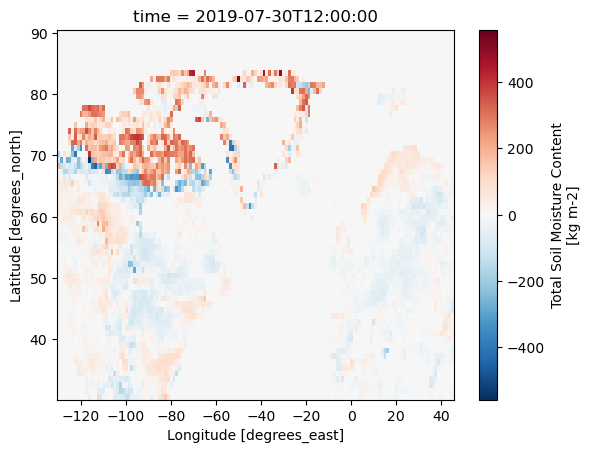

In [22]:
anom_xr.isel(time=210)['mrso'].plot()

In [141]:
drivers_row = drivers_sub.iloc[0]

In [142]:

mask_df = pd.read_csv(f"{maskdir}{drivers_row['clmask_test3']}",index_col=[0])
cl_nr = drivers_row['cl_nr']
submask = mask_df[mask_df.cluster == cl_nr]
maskedanom = clint.mask_xr_w_df(var, anom_xr, submask, lsm, kind)


In [143]:
xrdf = maskedanom

<!-- ## lines from clint.mask_xr_w_df
<!-- Trying to understand why maskedanom has no datetime object -->

In [144]:
# ## Generate coordinates of all gridpoints around the 2x2
# exp_list = [clint.expand_res_grid(row) for index,row in submask.iterrows()] 
# ## Concatenate dataframes with all the new gridpoints
# exp_df = pd.concat(exp_list,ignore_index=True).reset_index(drop=True)
# exp_df['cluster'] = np.nanmean(submask['cluster']) #add the missing column so that it can be merged to submask
# ## Append the new gridpoints to the original 2x2 mask
# submask_exp = pd.concat([submask,exp_df],ignore_index=True).drop_duplicates().reset_index(drop=True)

# mask = submask_exp.assign(flag=1).set_index(["nodes_lon", "nodes_lat"]).flag.to_xarray().fillna(0).rename({"nodes_lon": "longitude", "nodes_lat": "latitude"})

# if (kind == 'hist'):
#     lonfield = 'lon'
#     latfield = 'lat'
# else:
#     lonfield = 'longitude'
#     latfield = 'latitude'


# coarse = mask.interp(longitude=xrdf[lonfield], 
#                      latitude=xrdf[latfield], 
#                      method="nearest")
# coarse = coarse.fillna(0)

# sub_xrdf1 = xrdf.where(coarse)
# sub_xrdf = apply_land_sea_mask(sub_xrdf, lsm, kind)

<!-- ## lines from clint.apply_land_sea_mask -->
<!-- Trying to understand why subxrdf has no datetime object -->

In [145]:
# if (kind == 'hist'):
#     lonfield = 'lon'
#     latfield = 'lat'
# else:
#     lonfield = 'longitude'
#     latfield = 'latitude'

# targetxr = sub_xrdf

# lsm_mask = lsm.interp(longitude=targetxr[lonfield], 
#                  latitude=targetxr[latfield], 
#                  method="nearest")
# lsm_mask = lsm_mask.squeeze('time')
# lsm_mask2 = lsm_mask1.fillna(0)

# outputxr = targetxr.where(lsm_mask['lsm'])

## lines from clint.multimaps_lag 

In [146]:
targetdate_ts = date_ts

In [157]:
targetdate_ts

Timestamp('2019-06-27 12:00:00')

In [158]:
minlag = int(drivers_row['minlag'])
maxlag = int(drivers_row['maxlag'])
fig_width = drivers_row['fig_width']
if np.isnan(fig_width):
    fig_width = 48

ax_width = drivers_row['ax_width']
if np.isnan(ax_width):
    ax_width = 12

ax_height = drivers_row['ax_height']
if np.isnan(ax_height):
    ax_height = 8

text_plot_lon = drivers_row['text_plot_lon']
if np.isnan(text_plot_lon):
    text_plot_lon = drivers_row['cl_ext_E']-2

text_plot_lat = drivers_row['text_plot_lat']
if np.isnan(text_plot_lat):
    text_plot_lat = drivers_row['cl_ext_N']-2

targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d')

y = targetdate_ts.year
m = str(targetdate_ts.month).zfill(2)
d = str(targetdate_ts.day).zfill(2)


In [159]:
var = drivers_row['var']
# Determine extremes of the date range considered, in the netcdf every day has 12:00 as hour
mintime_ts = targetdate_ts - pd.DateOffset(days = maxlag) + pd.DateOffset(hours = 12)
maxtime_ts = targetdate_ts - pd.DateOffset(days = minlag) + pd.DateOffset(hours = 12)

mintime_str = dt.strftime(mintime_ts,'%Y-%m-%d')
maxtime_str = dt.strftime(mintime_ts,'%Y-%m-%d')

numfigs = len(range(minlag,maxlag+1))
numfigs_h = np.floor(fig_width/ax_width)
numfigs_v = np.ceil(numfigs/numfigs_h)


In [160]:
vmin = 'drivers'
vmax = 'drivers'

In [161]:
if vmin == 'drivers':
    vmin = drivers_row['vmin']
if vmax == 'drivers':
    vmax = drivers_row['vmax']
var = drivers_row['var']

In [162]:
##NEW
if kind == 'era5':
    nc_var = drivers_row.nc_var
else:
    nc_var = drivers_row.cmip6_var

In [163]:
if var == 'tmax':
    palette = plt.cm.RdBu_r
if var == 'mslp':
    palette = plt.cm.PRGn_r
if var == 'sm':
    palette = plt.cm.BrBG

targetdate_str = dt.strftime(targetdate_ts,'%Y-%m-%d %H')

In [166]:
f = 0
lag = 0 

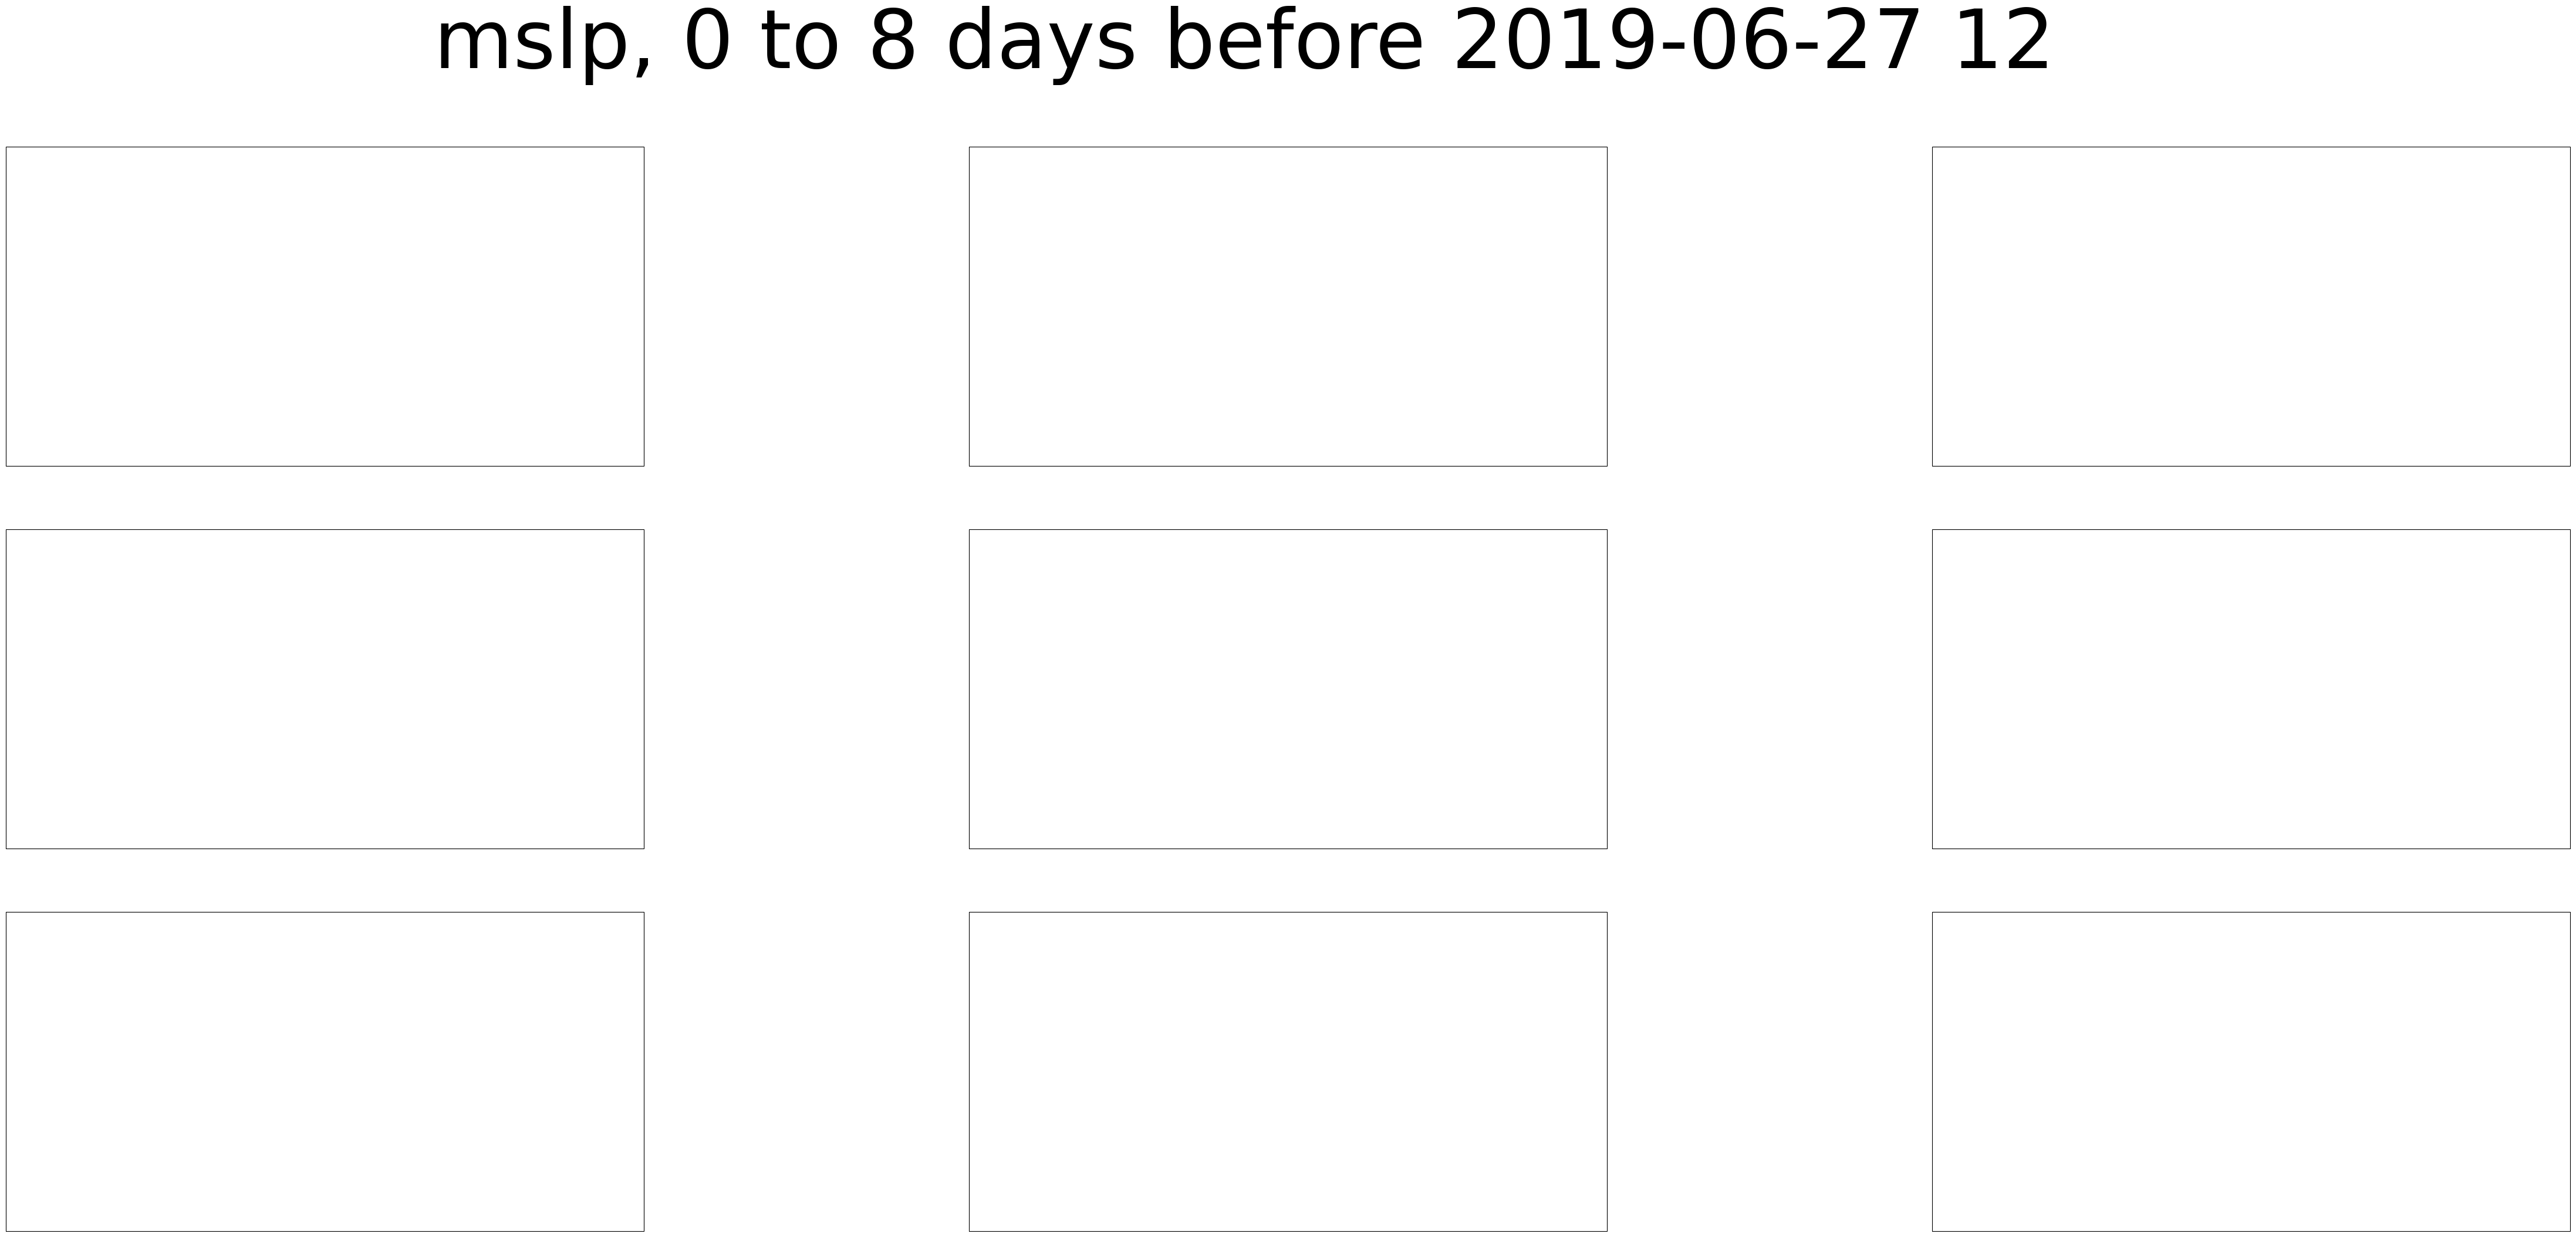

In [167]:
### START HERE


cl_name = drivers_row['cluster']
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(int(numfigs_v), int(numfigs_h),
                        subplot_kw={'projection': proj},
                        figsize=(fig_width,int(numfigs_v*ax_height)),
                        sharey=True,sharex=True)#,
                        #layout="constrained")
fig.suptitle(f'{var}, {minlag} to {maxlag} days before {targetdate_str}', fontsize = 100)
axs = axs.flatten()        

In [124]:
#for f,lag in enumerate(range(minlag,maxlag+1)):

In [168]:
    plotdate_ts = targetdate_ts - pd.DateOffset(days = lag)# + pd.DateOffset(hours = 12)

In [169]:
plotdate_ts

Timestamp('2019-06-27 12:00:00')

In [170]:
xrdf['time']

<xarray.DataArray 'time' (time: 365)>
array(['2019-01-01T12:00:00.000000000', '2019-01-02T12:00:00.000000000',
       '2019-01-03T12:00:00.000000000', ..., '2019-12-29T12:00:00.000000000',
       '2019-12-30T12:00:00.000000000', '2019-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T12:00:00 ... 2019-12-31T12:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [171]:
    sub1d = xrdf.sel(time=plotdate_ts)

Text(0.5, 1.0, '')

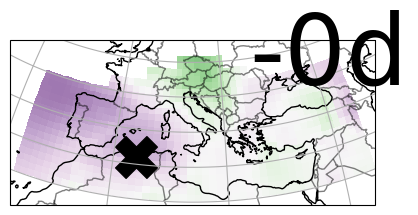

In [172]:
    axs[f].remove()
    geo_axes = plt.subplot(int(numfigs_v), int(numfigs_h), f+1,
                           projection=ccrs.Orthographic(central_longitude=drivers_row['cl_ortho_lon'],
                                                        central_latitude=drivers_row['cl_ortho_lat']))

    cs=sub1d[nc_var].plot(ax=geo_axes,transform=ccrs.PlateCarree(),cmap=palette, 
                       vmin = vmin, vmax = vmax,add_colorbar=False)
    geo_axes.set_extent(drivers_row[['cl_ext_W','cl_ext_E','cl_ext_S','cl_ext_N']])    
    geo_axes.scatter(x=drivers_row['cluster_centre_lon'], y=drivers_row['cluster_centre_lat'],
                marker='X',color='black',s=900,transform=ccrs.PlateCarree(),alpha=1)
    geo_axes.coastlines()
    geo_axes.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    #geo_axes.text(x=text_plot_lon, y=text_plot_lat, 
    #              s=f'-{lag}d', transform=ccrs.PlateCarree(), fontsize=70)
    geo_axes.text(x=0.875, y=0.9, horizontalalignment='center', verticalalignment='center',
                  s=f'-{lag}d', transform=geo_axes.transAxes, fontsize=70)

    geo_axes.gridlines()
    plt.title(None)
    #plt.title(f'-{lag}d', fontsize = 50)
    #geo_axes._legend.remove()

In [77]:
what = 'centroid'
y = targetdate_ts.year
m = str(targetdate_ts.month).zfill(2)
d = str(targetdate_ts.day).zfill(2)

vmin = drivers_row['vmin']
vmax = drivers_row['vmax']

##NEW
if (kind == 'hist'):
    lonfield = 'lon'
    latfield = 'lat'
    nc_var = drivers_row.cmip6_var
else:
    lonfield = 'longitude'
    latfield = 'latitude'
    nc_var = drivers_row.era5_var

        


In [67]:
xrdf.sel({lonfield : cc_lon, latfield : cc_lat}, method = 'nearest')

<xarray.Dataset>
Dimensions:    (time: 365, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01T12:00:00 ... 2019-12-31T12:00:00
    lon        float64 13.75
    lat        float64 54.19
    height     float64 2.0
    longitude  float64 13.75
    latitude   float64 54.19
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object nan nan nan nan nan ... nan nan nan nan nan
    lon_bnds   (bnds, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    lat_bnds   (bnds, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    tasmax     (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/50)
    CDI:                    Climate Data Interface version 2.2.1 (https://mpi...
    Conventions:            CF-1.7 CMIP-6.2
    source:                 CMCC-CM2-SR5 (2016): \naerosol: MAM3\natmos: CAM5...
    institution:            Fondazione Centro Euro-Mediterraneo sui Cambiamen...
    activity_id:            ScenarioMIP
    branch_method:          standard
    ...                     ...
    variable_id:            tasmax
    variant_label:          r3i1p2f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/55724fbc-7343-41bf-b064-e833d942db28
    CDO:                    Climate Data Operators version 2.2.0 (https://mpi...

In [81]:
if what == 'centroid':
    cc_lon = drivers_row['cluster_centre_lon']
    cc_lat = drivers_row['cluster_centre_lat']
    cc_lon = 8
    cc_lat = 46
    cc_ser = xrdf.sel({lonfield : cc_lon, latfield : cc_lat}, method = 'nearest') ##NEW       
if what == 'average':
    cc_ser = xrdf.mean(dim=[lonfield,latfield])#average on the whole domain
if what == 'quantiles':        
    cc_ser75 = xrdf.quantile(q=0.75, dim=[lonfield,latfield])#average on the whole domain
    cc_ser10 = xrdf.quantile(q=0.10, dim=[lonfield,latfield])#average on the whole domain
    cc_ser25 = xrdf.quantile(q=0.25, dim=[lonfield,latfield])#average on the whole domain
    cc_ser50 = xrdf.quantile(q=0.50, dim=[lonfield,latfield])#average on the whole domain
    cc_ser90 = xrdf.quantile(q=0.90, dim=[lonfield,latfield])#average on the whole domain

In [79]:
kind

'hist'

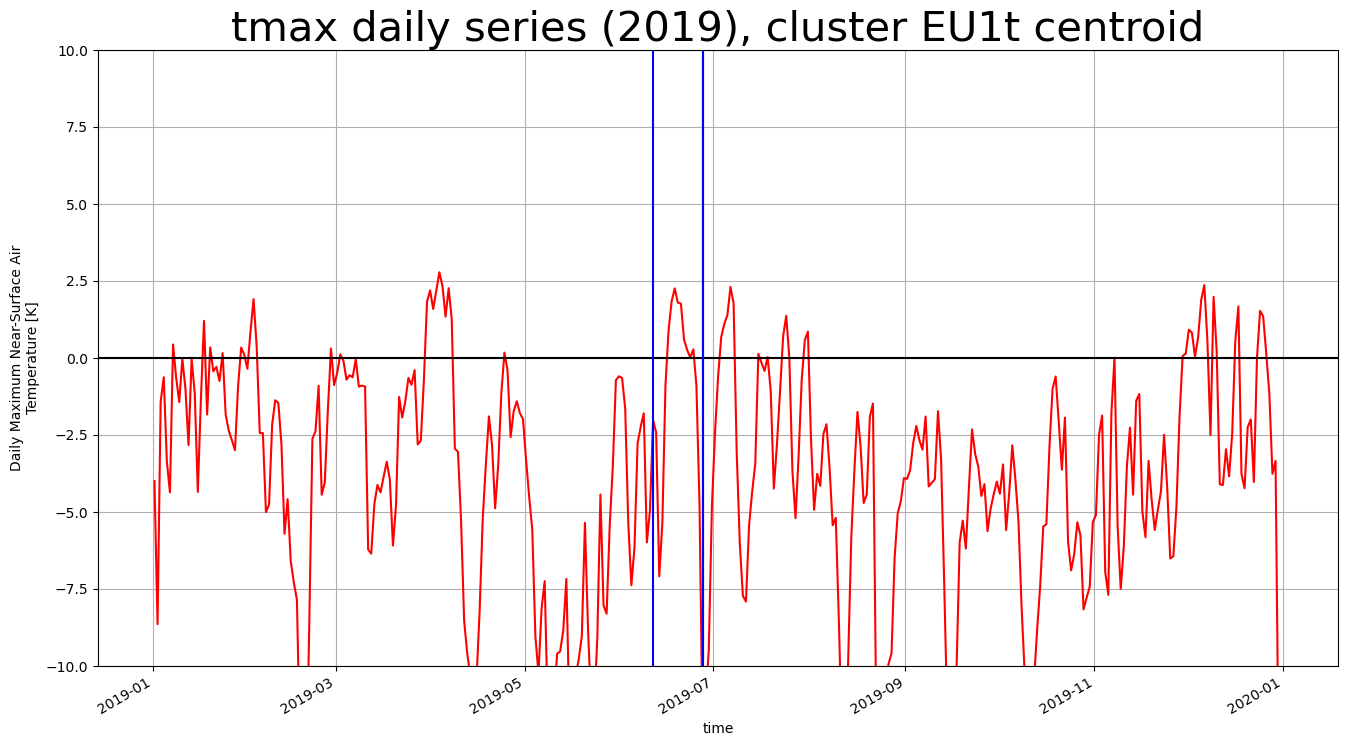

In [82]:
        
    
    var = drivers_row['var']
    #nc_var = drivers_row[nc_va]
    cl_name = drivers_row['cluster']
    
    minlag = int(drivers_row['minlag'])
    maxlag = int(drivers_row['maxlag'])
    # Determine extremes of the date range considered
    mintime_ts = targetdate_ts - pd.DateOffset(days = maxlag)# + pd.DateOffset(hours = 12)
    maxtime_ts = targetdate_ts - pd.DateOffset(days = minlag)# + pd.DateOffset(hours = 12)
    
    plt.rcParams['figure.figsize'] = [16,8]
    #plt.figure(figsize=((16,8)))
    fig,ax = plt.subplots()
    if what == 'centroid':
        cc_ser[nc_var].plot(color='red')
    if what == 'average':
        cc_ser[nc_var].plot(color='sienna')
    if what == 'quantiles':
        ax.fill_between(x=cc_ser10['time'],y1=cc_ser10[nc_var],y2=cc_ser90[nc_var],color='mistyrose')
        ax.fill_between(x=cc_ser25['time'],y1=cc_ser25[nc_var],y2=cc_ser75[nc_var],color='pink')
        cc_ser50[nc_var].plot(color='mediumvioletred')

        
    ax.set_ylim(vmin,vmax)   
    plt.title(f'{var} daily series ({y}), cluster {cl_name} {what}',fontsize=30)
    plt.axhline(y=0, color='k')
    plt.axvline(x = targetdate_ts, color = 'k', label = 'axvline - full height')
    plt.axvline(x = mintime_ts, color = 'b', label = 'axvline - full height')
    plt.axvline(x = maxtime_ts, color = 'b', label = 'axvline - full height')
    plt.grid()
    plt.savefig(f"{plotdir}CLINT050_{y}{m}{d}case_{var}_{cl_name}_{what}.png", facecolor='w')
    plt.show()

  